In [1]:
import os
import PIL
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import models
from keras.models import load_model
import matplotlib.pyplot as plt

# 1. Accessing dataset and the FaceNet model

In [2]:
from zipfile import ZipFile
ZipFile("/content/drive/MyDrive/keras-facenet-20210607T071758Z-001.zip").extractall("/content/sample_data/facenet")
ZipFile("/content/drive/MyDrive/FaceExtracts- The Office S06E01.zip").extractall("/content/sample_data/dataset")


# 2. Loading the train test image data

In [3]:
! pip install split-folders

In [4]:
import splitfolders

splitfolders.ratio("/content/sample_data/dataset/FaceExtracts/", output="/content/sample_data/splitted_data", seed=1337, ratio=(.7, .3), group_prefix=None) # default values


Copying files: 1011 files [00:00, 6877.98 files/s]


In [5]:
def extract_f(file_name,required_size=(160,160)):
    image = Image.open(file_name)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    image = Image.fromarray(pixels)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array


def load_face(dir):
    faces = list()
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_f(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir))
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


X_train, Y_train = load_dataset('/content/sample_data/splitted_data/train/')
print(X_train.shape, Y_train.shape)


X_test, Y_test = load_dataset('/content/sample_data/splitted_data/val/')
print(X_test.shape, Y_test.shape)

loaded 279 sample for class: Michael
loaded 14 sample for class: Intern3
loaded 37 sample for class: Dwight
loaded 23 sample for class: Kevin
loaded 9 sample for class: Phylis
loaded 9 sample for class: Meredith
loaded 5 sample for class: Erin
loaded 11 sample for class: Intern2
loaded 4 sample for class: Creed
loaded 98 sample for class: Jim
loaded 32 sample for class: Pam
loaded 10 sample for class: Kelly
loaded 69 sample for class: Andy
loaded 46 sample for class: Oscar
loaded 14 sample for class: Stanley
loaded 13 sample for class: Angela
loaded 26 sample for class: Intern1
(699, 160, 160, 3) (699,)
loaded 120 sample for class: Michael
loaded 7 sample for class: Intern3
loaded 16 sample for class: Dwight
loaded 11 sample for class: Kevin
loaded 5 sample for class: Phylis
loaded 4 sample for class: Meredith
loaded 3 sample for class: Erin
loaded 6 sample for class: Intern2
loaded 3 sample for class: Creed
loaded 43 sample for class: Jim
loaded 14 sample for class: Pam
loaded 5 sampl

# 3. Loading the FaceNet model and creating a function to create facial embeddings.

In [6]:
facenet_model = load_model('/content/sample_data/facenet/keras-facenet/model/facenet_keras.h5')

def get_embedding(model, face):
    face = face.astype('float32')
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    sample = np.expand_dims(face, axis=0)
    yhat = model.predict(sample)
    return yhat[0]

# 4. Using the embedding function, getting the embedded face values for both train and test data

In [7]:
emd_X_train = list()
for face in X_train:
    emd = get_embedding(facenet_model, face)
    emd_X_train.append(emd)
emd_X_train = np.asarray(emd_X_train)
print(emd_X_train.shape)


emd_X_test = list()
for face in X_test:
    emd = get_embedding(facenet_model, face)
    emd_X_test.append(emd)
emd_X_test = np.asarray(emd_X_test)
print(emd_X_test.shape)

Cause: could not parse the source code of <function <lambda> at 0x7f78fee13f80>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f78fee13f80>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f78fee13b90>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f78fee13b90>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f78fee13d40>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could no

# 5. Pre-processing before the classification

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import Normalizer


#preprocess features

No = Normalizer()
x_train_normalized= No.transform(emd_X_train)

x_test_normalized = No.transform(emd_X_test)

In [9]:
#preprocess labels

oc=OneHotEncoder(handle_unknown='ignore')
le = LabelEncoder()
le.fit(Y_train)
train_label = le.transform(Y_train)
y_train=oc.fit_transform(train_label.reshape(-1,1)).toarray()

test_label = le.transform(Y_test)
y_test=oc.fit_transform(test_label.reshape(-1,1)).toarray()

# 6. Classification using Artificial Neural Network

In [10]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=128,activation='relu'))
model.add(tf.keras.layers.Dense(units=256,activation='relu'))
model.add(tf.keras.layers.Dense(units=17,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
model.fit(x_train_normalized,y_train, epochs=30,batch_size=32)

Epoch 1/30
22/22 [==============================] - 1s 2ms/step - loss: 2.3806 - accuracy: 0.5379 
Epoch 2/30
22/22 [==============================] - 0s 2ms/step - loss: 1.0811 - accuracy: 0.6767
Epoch 3/30
22/22 [==============================] - 0s 2ms/step - loss: 0.5835 - accuracy: 0.8670
Epoch 4/30
22/22 [==============================] - 0s 2ms/step - loss: 0.3469 - accuracy: 0.9285
Epoch 5/30
22/22 [==============================] - 0s 2ms/step - loss: 0.2064 - accuracy: 0.9714
Epoch 6/30
22/22 [==============================] - 0s 2ms/step - loss: 0.1256 - accuracy: 0.9843
Epoch 7/30
22/22 [==============================] - 0s 2ms/step - loss: 0.0791 - accuracy: 0.9900
Epoch 8/30
22/22 [==============================] - 0s 2ms/step - loss: 0.0503 - accuracy: 0.9957
Epoch 9/30
22/22 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 1.0000
Epoch 10/30
22/22 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 1.0000
Epoch 11/30
22/22 

In [12]:
loss, acc= model.evaluate(emd_X_test,y_test)

print("Test accuracy=",acc)

10/10 [==============================] - 0s 2ms/step - loss: 0.1684 - accuracy: 0.9840
Test accuracy= 0.9839743375778198


In [13]:
loss, acc= model.evaluate(emd_X_train,y_train)

print("Train accuracy=",acc)

22/22 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Train accuracy= 1.0


# 7. Predicting on random samples

Expectation: Oscar
Predicted:


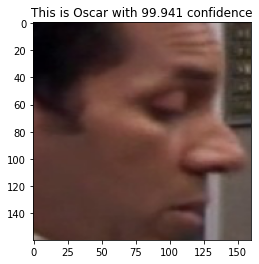

In [17]:
from random import randrange

le.fit(Y_test)
temp=randrange(312)

random_face = X_test[temp]
random_face_emd = x_test_normalized[temp]
random_face_class = y_test[temp]

samples = np.expand_dims(random_face_emd, axis=0)

yhat_class = model.predict_classes(samples)
yhat_prob = model.predict_proba(samples)

print('Expectation: %s' % Y_test[temp])
print('Predicted:')
plt.imshow(random_face)
title = 'This is %s with %.3f confidence' % (le.classes_[yhat_class[0]], yhat_prob[0][yhat_class[0]]*100)
plt.title(title)
plt.show()

Expectation: Angela
Predicted:


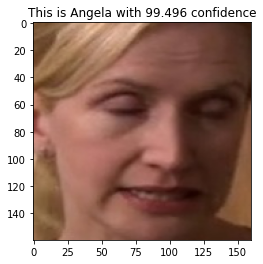

In [18]:
from random import randrange

le.fit(Y_test)
temp=randrange(312)

random_face = X_test[temp]
random_face_emd = x_test_normalized[temp]
random_face_class = y_test[temp]

samples = np.expand_dims(random_face_emd, axis=0)

yhat_class = model.predict_classes(samples)
yhat_prob = model.predict_proba(samples)

print('Expectation: %s' % Y_test[temp])
print('Predicted:')
plt.imshow(random_face)
title = 'This is %s with %.3f confidence' % (le.classes_[yhat_class[0]], yhat_prob[0][yhat_class[0]]*100)
plt.title(title)
plt.show()

Expectation: Michael
Predicted:


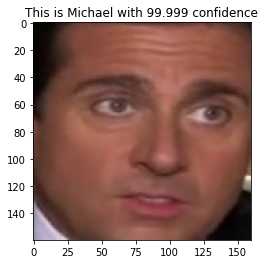

In [19]:
from random import randrange

le.fit(Y_test)
temp=randrange(312)

random_face = X_test[temp]
random_face_emd = x_test_normalized[temp]
random_face_class = y_test[temp]

samples = np.expand_dims(random_face_emd, axis=0)

yhat_class = model.predict_classes(samples)
yhat_prob = model.predict_proba(samples)

print('Expectation: %s' % Y_test[temp])
print('Predicted:')
plt.imshow(random_face)
title = 'This is %s with %.3f confidence' % (le.classes_[yhat_class[0]], yhat_prob[0][yhat_class[0]]*100)
plt.title(title)
plt.show()

Expectation: Michael
Predicted:


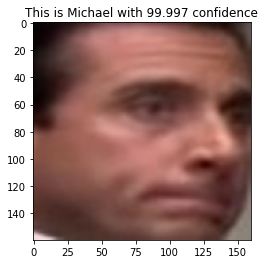

In [20]:
from random import randrange

le.fit(Y_test)
temp=randrange(312)

random_face = X_test[temp]
random_face_emd = x_test_normalized[temp]
random_face_class = y_test[temp]

samples = np.expand_dims(random_face_emd, axis=0)

yhat_class = model.predict_classes(samples)
yhat_prob = model.predict_proba(samples)

print('Expectation: %s' % Y_test[temp])
print('Predicted:')
plt.imshow(random_face)
title = 'This is %s with %.3f confidence' % (le.classes_[yhat_class[0]], yhat_prob[0][yhat_class[0]]*100)
plt.title(title)
plt.show()

Expectation: Jim
Predicted:


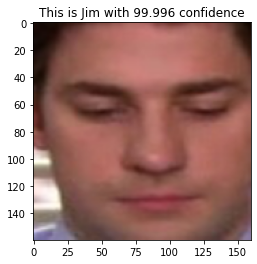

In [21]:
from random import randrange

le.fit(Y_test)
temp=randrange(312)

random_face = X_test[temp]
random_face_emd = x_test_normalized[temp]
random_face_class = y_test[temp]

samples = np.expand_dims(random_face_emd, axis=0)

yhat_class = model.predict_classes(samples)
yhat_prob = model.predict_proba(samples)

print('Expectation: %s' % Y_test[temp])
print('Predicted:')
plt.imshow(random_face)
title = 'This is %s with %.3f confidence' % (le.classes_[yhat_class[0]], yhat_prob[0][yhat_class[0]]*100)
plt.title(title)
plt.show()